# Boosting Classification

### 1. Setup and Data Loading

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
import time
import os

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import warnings
warnings.filterwarnings('ignore')

In [10]:
DATA_PATH = os.path.join(os.path.dirname(os.getcwd()), 'data', 'RHMD_Engineered.csv')
df = pd.read_csv(DATA_PATH)

In [11]:
print(f"Dataset shape: {df.shape}")
print("\nColumns in the dataset:")
print(df.columns.tolist())

Dataset shape: (20355, 40)

Columns in the dataset:
['author', 'score', 'subreddit', 'timestamp', 'title', 'text', 'year_month', 'year', 'month', 'day', 'day_of_week', 'hour', 'title_word_count', 'title_char_count', 'text_word_count', 'text_char_count', 'total_word_count', 'pre_covid', 'pandemic_phase', 'title_sentiment', 'text_sentiment', 'overall_sentiment', 'textblob_sentiment', 'textblob_subjectivity', 'negative_emotion', 'positive_emotion', 'sadness', 'fear', 'death', 'suffering', 'pain', 'shame', 'violence', 'love', 'optimism', 'tokens', 'dominant_topic', 'topic_contribution', 'topic_keywords', 'distress_score']


### 2. Data Preparation

In [14]:
feature_columns = [
    'title_sentiment', 'text_sentiment', 'overall_sentiment', 'textblob_sentiment', 'textblob_subjectivity',
    'negative_emotion', 'positive_emotion', 'sadness', 'fear', 'death', 'suffering', 'pain', 'shame', 'violence', 'love', 'optimism',
    'title_word_count', 'text_word_count',
    'dominant_topic', 'topic_contribution',
    'distress_score'
]

In [15]:
X = df[feature_columns]
y = df['subreddit']

In [16]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [17]:
for i, subreddit in enumerate(label_encoder.classes_):
    print(f"{subreddit} -> {i}")

Anxiety -> 0
SuicideWatch -> 1
depression -> 2
lonely -> 3
mentalhealth -> 4


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [19]:
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (16284, 21)
Testing set shape: (4071, 21)


### 3. Baseline Model

In [20]:
baseline_model = GradientBoostingClassifier(random_state=42)

In [21]:
start_time = time.time()
baseline_model.fit(X_train, y_train)
end_time = time.time()

In [22]:
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Training time: 47.80 seconds


In [24]:
y_pred = baseline_model.predict(X_test)

In [25]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline model accuracy: {accuracy:.4f}")

Baseline model accuracy: 0.4866


In [26]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.64      0.69      0.67       872
SuicideWatch       0.46      0.55      0.50       792
  depression       0.37      0.24      0.29       755
      lonely       0.47      0.59      0.53       817
mentalhealth       0.41      0.33      0.36       835

    accuracy                           0.49      4071
   macro avg       0.47      0.48      0.47      4071
weighted avg       0.48      0.49      0.48      4071



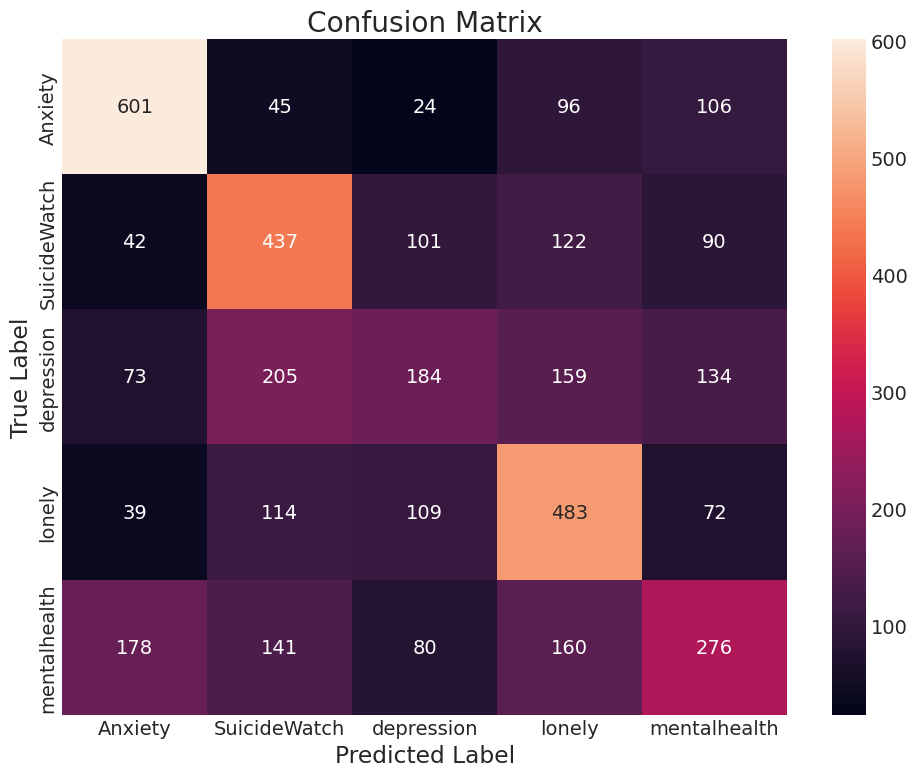

In [29]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 4. Feature Importance

In [30]:
feature_importance = baseline_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

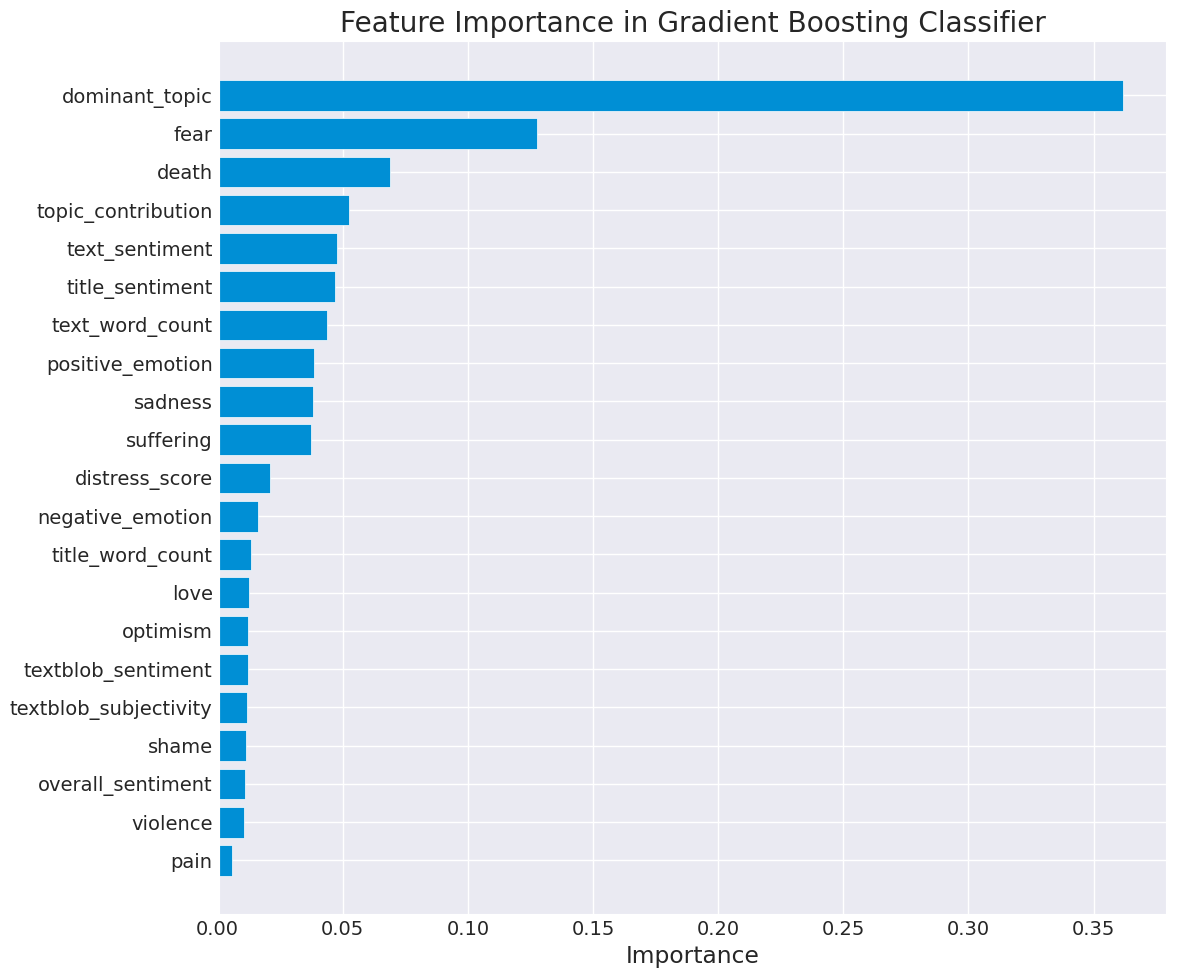

In [31]:
plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_columns)[sorted_idx])
plt.title('Feature Importance in Gradient Boosting Classifier')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### 5. Hyperparameter Optimization

In [37]:
param_space = {
    'n_estimators': Integer(50, 300),
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'max_depth': Integer(3, 7),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'subsample': Real(0.6, 1.0, prior='uniform')
}

In [38]:
bayes_search = BayesSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    search_spaces=param_space,
    n_iter=20,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [39]:
start_time = time.time()
bayes_search.fit(X_train, y_train)
end_time = time.time()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [40]:
tuning_time = end_time - start_time
print(f"Bayesian Optimization time: {tuning_time:.2f} seconds")

Bayesian Optimization time: 1969.71 seconds


In [41]:
print(f"Best parameters: {bayes_search.best_params_}")
print(f"Best cross-validation accuracy: {bayes_search.best_score_:.4f}")

Best parameters: OrderedDict({'learning_rate': 0.0559964758435538, 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 92, 'subsample': 0.9772482121002506})
Best cross-validation accuracy: 0.4712


In [43]:
best_gb_model = bayes_search.best_estimator_

In [44]:
y_pred_best = best_gb_model.predict(X_test)

In [45]:
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best model accuracy on test set: {accuracy_best:.4f}")
print(f"Improvement over baseline: {(accuracy_best - accuracy) * 100:.2f}%")

Best model accuracy on test set: 0.4891
Improvement over baseline: 0.25%


In [46]:
print("\nClassification Report for Best Model:")
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))


Classification Report for Best Model:
              precision    recall  f1-score   support

     Anxiety       0.66      0.70      0.68       872
SuicideWatch       0.46      0.55      0.50       792
  depression       0.38      0.26      0.31       755
      lonely       0.47      0.58      0.52       817
mentalhealth       0.41      0.33      0.37       835

    accuracy                           0.49      4071
   macro avg       0.48      0.48      0.47      4071
weighted avg       0.48      0.49      0.48      4071



In [49]:
xgb_param_space = {
    'n_estimators': Integer(50, 300),
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'subsample': Real(0.6, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.6, 1.0, prior='uniform'),
    'gamma': Real(0.1, 5, prior='log-uniform'),
    'min_child_weight': Integer(1, 10)
}

In [52]:
xgb_bayes_search = BayesSearchCV(
    estimator=xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    search_spaces=xgb_param_space,
    n_iter=15,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

In [56]:
start_time = time.time()
xgb_bayes_search.fit(X_train, y_train)
end_time = time.time()

/home/madhav/SEM-2/TM/Subreddit-Sentinel/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:39:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/madhav/SEM-2/TM/Subreddit-Sentinel/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:39:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/madhav/SEM-2/TM/Subreddit-Sentinel/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:39:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/madhav/SEM-2/TM/Subreddit-Sentinel/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:39:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bs

In [57]:
xgb_tuning_time = end_time - start_time
print(f"XGBoost Bayesian Optimization time: {xgb_tuning_time:.2f} seconds")

XGBoost Bayesian Optimization time: 158.93 seconds


In [59]:
print(f"Best XGBoost parameters: {xgb_bayes_search.best_params_}")
print(f"Best cross-validation accuracy: {xgb_bayes_search.best_score_:.4f}")

Best XGBoost parameters: OrderedDict({'colsample_bytree': 0.6014521229018973, 'gamma': 2.45170759286383, 'learning_rate': 0.09213636741693375, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 119, 'subsample': 0.7251357224938513})
Best cross-validation accuracy: 0.4710


In [60]:
best_xgb_model = xgb_bayes_search.best_estimator_

In [61]:
xgb_pred_best = best_xgb_model.predict(X_test)
xgb_accuracy_best = accuracy_score(y_test, xgb_pred_best)
print(f"Best XGBoost model accuracy on test set: {xgb_accuracy_best:.4f}")

Best XGBoost model accuracy on test set: 0.4901


In [62]:
print("\nClassification Report for Best XGBoost Model:")
print(classification_report(y_test, xgb_pred_best, target_names=label_encoder.classes_))


Classification Report for Best XGBoost Model:
              precision    recall  f1-score   support

     Anxiety       0.66      0.69      0.67       872
SuicideWatch       0.46      0.55      0.50       792
  depression       0.39      0.25      0.30       755
      lonely       0.48      0.60      0.53       817
mentalhealth       0.40      0.34      0.37       835

    accuracy                           0.49      4071
   macro avg       0.48      0.48      0.47      4071
weighted avg       0.48      0.49      0.48      4071

